In [1]:
import CommonFunc
import pandas as pd

import CommonFunc
import pandas as pd

df = pd.read_csv('resources/co2_emmision_train_data.csv')
mask = df['CO2 Emissions (g/km)'] == 0
df = df[~mask]
df.drop_duplicates()
df.rename(columns={ 'Engine Size (L)': 'Engine Size(L)',
                    'Fuel Consumption [City (L/100 km)]': 'Fuel Consumption City (L/100 km)',
                    'Fuel Consumption [Hwy (L/100 km)]': 'Fuel Consumption Hwy (L/100 km)',
                    'Fuel Consumption [Comb (L/100 km)]': 'Fuel Consumption Comb (L/100 km)',
                    'CO2 Emissions (g/km)': 'CO2 Emissions(g/km)'
                    }, inplace=True)
df = df[~df['Fuel Type'].isin(['?','','nan','N'])]
df.dropna(subset=['Fuel Type'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26961 entries, 0 to 27548
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Year                                  26961 non-null  float64
 1   Make                                  26961 non-null  object 
 2   Model                                 26961 non-null  object 
 3   Vehicle Class                         26961 non-null  object 
 4   Engine Size(L)                        26961 non-null  float64
 5   Cylinders                             26961 non-null  float64
 6   Transmission                          26961 non-null  object 
 7   Fuel Type                             26961 non-null  object 
 8   Fuel Consumption City (L/100 km)      26961 non-null  float64
 9   Fuel Consumption Hwy (L/100 km)       26961 non-null  float64
 10  Fuel Consumption Comb (L/100 km)      26961 non-null  float64
 11  Fuel Consumption [Co

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Готовим данные
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.preprocessing import LabelEncoder

#удаляем дубликаты
df.drop_duplicates()

df_shafling = df.sample(frac = 1)
df_part = df_shafling[:3000]

#выделяем числовые данные
numdata = pd.DataFrame(df_part[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Year',
                           'CO2 Emissions(g/km)']])

# Делаем энкодинг для категориальных признаков
label_encoder_2 = LabelEncoder()
label_encoder_3 = LabelEncoder()


fuel_type = df_part[['Fuel Type']].values.ravel()
transmission = df_part[['Transmission']].values.ravel()

encoded_fuel_type = label_encoder_2.fit_transform(fuel_type)
encoded_transmission = label_encoder_3.fit_transform(transmission)

enc_2 = dict(zip(label_encoder_2.classes_,range(len(label_encoder_2.classes_))))
enc_3 = dict(zip(label_encoder_3.classes_,range(len(label_encoder_3.classes_))))


print(CommonFunc.printDict(enc_2))
print(CommonFunc.printDict(enc_3))

D   0
E   1
X   2
Z   3

A10   0
A3   1
A4   2
A5   3
A6   4
A7   5
A8   6
A9   7
AM6   8
AM7   9
AM8   10
AM9   11
AS10   12
AS4   13
AS5   14
AS6   15
AS7   16
AS8   17
AS9   18
AV   19
AV10   20
AV6   21
AV7   22
AV8   23
M5   24
M6   25
M7   26



In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Составляем матрицу данных X
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

X_ = numdata[['Engine Size(L)', 'Cylinders','Year', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']]
X_['Transmission'] = encoded_transmission
X_['Fuel Type'] = encoded_fuel_type
feature_names = X_.columns
X=X_.values

print(len(X))
#Составляем и упрощаем до одномерного массива набор целевой переменной
y = numdata[['CO2 Emissions(g/km)']].values.ravel()

3000


*****************
Метрики качества:
*****************
MAE: 1.9126666667
MSE: 56.9136440000
RMSE: 7.5441132017
R²: 0.9889842331


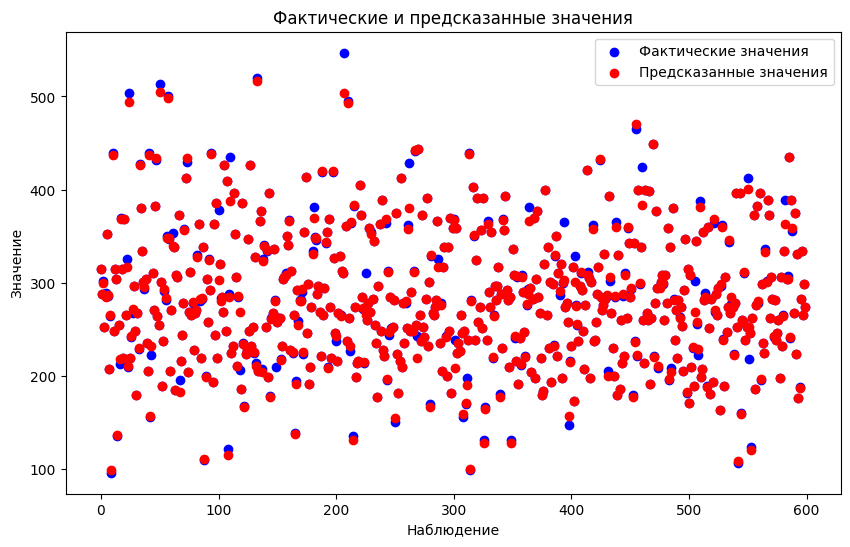

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\CommonFunc.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


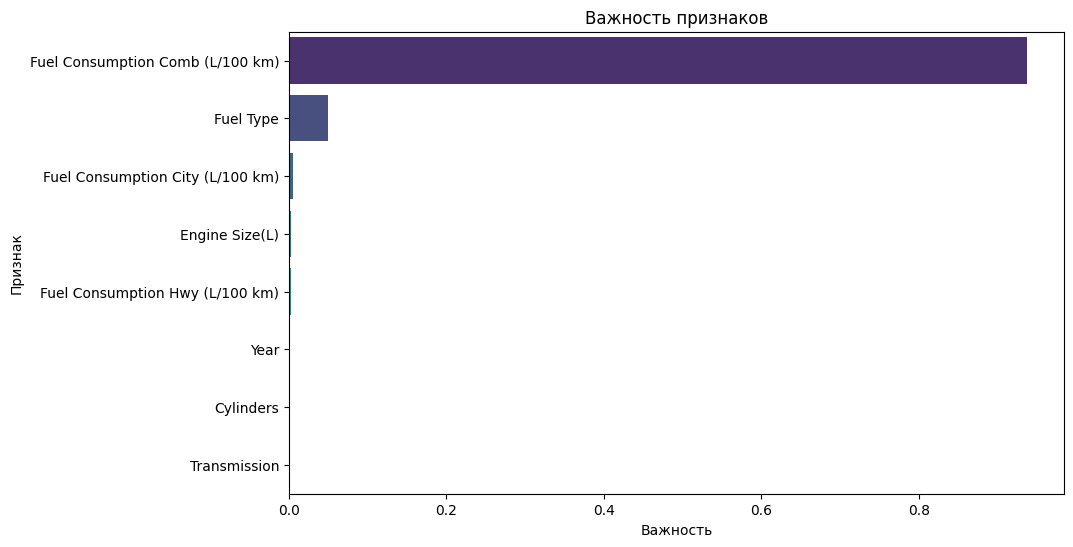

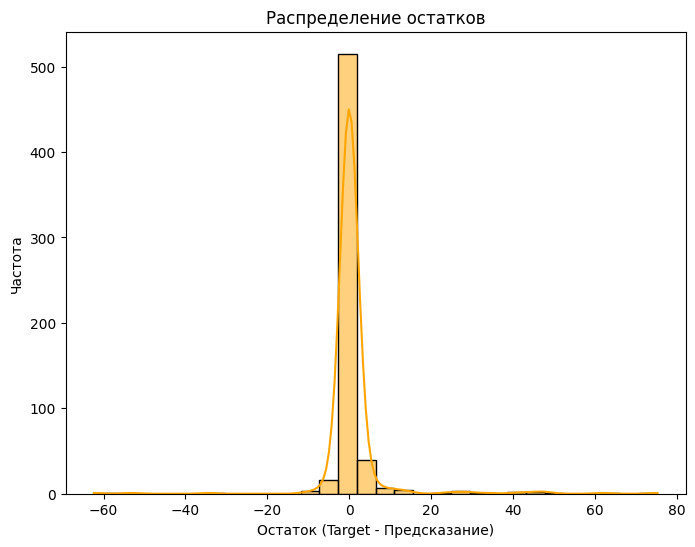

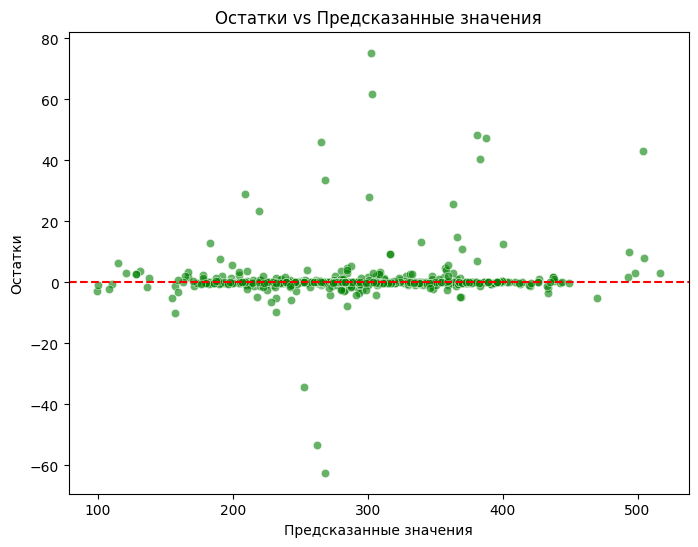

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Простой Random Forest на всех колонках
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Используем Random Forest чтобы найти наиболее важные признаки
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

# Важность признаков
CommonFunc.getImportances(rfr.feature_importances_, feature_names)

# Остатки
CommonFunc.getRemains(y_test, y_pred)


In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#дропаем не влияющие на результат колонки
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

X_ = X_.drop(columns=['Fuel Consumption Hwy (L/100 km)', 'Transmission', 'Cylinders'])
X=X_.values

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best parameters found: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
*****************
Метрики качества:
*****************
MAE: 2.3521633333
MSE: 41.9859421437
RMSE: 6.4796560205
R²: 0.9918735242


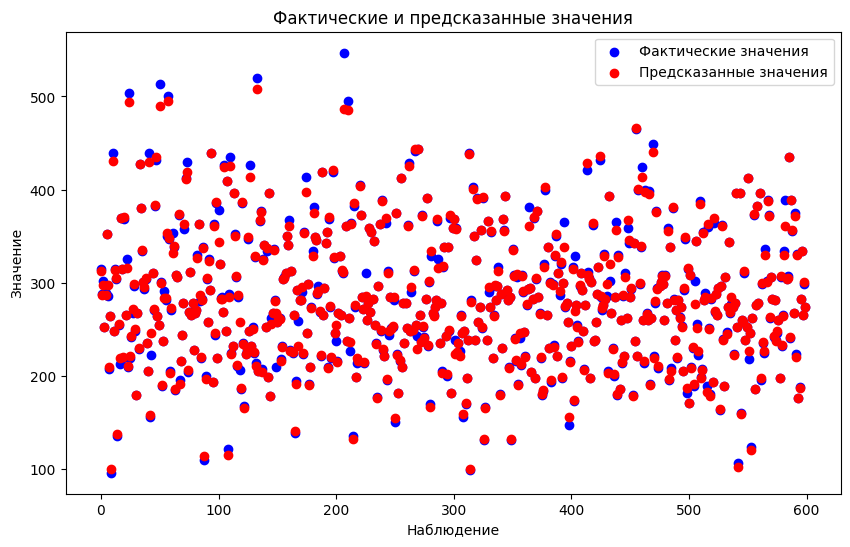

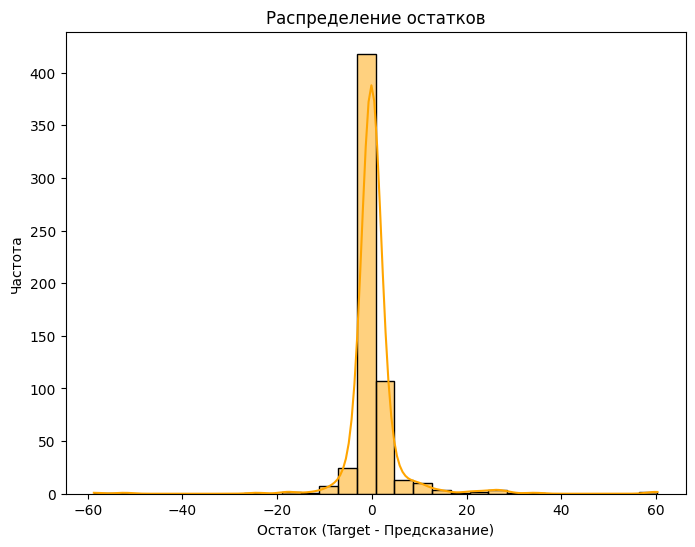

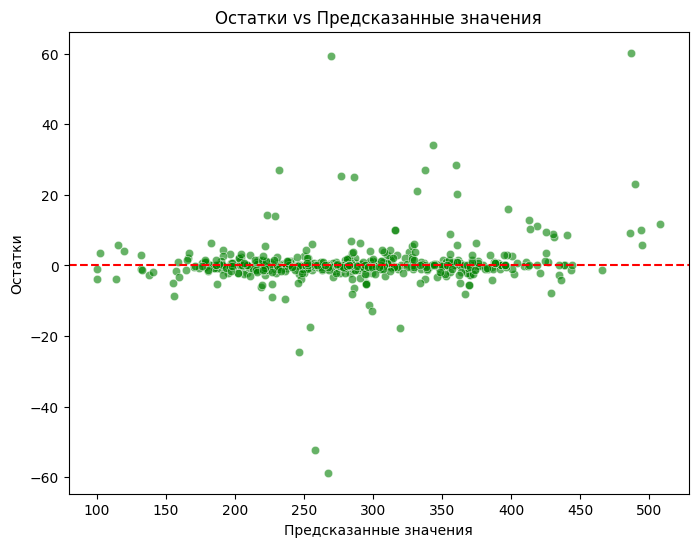

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Random Forest Regressor с использованием GridSearchCV
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_data_part_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 1.9119826212
MSE: 9.9201279890
RMSE: 3.1496234678
R²: 0.9980799364


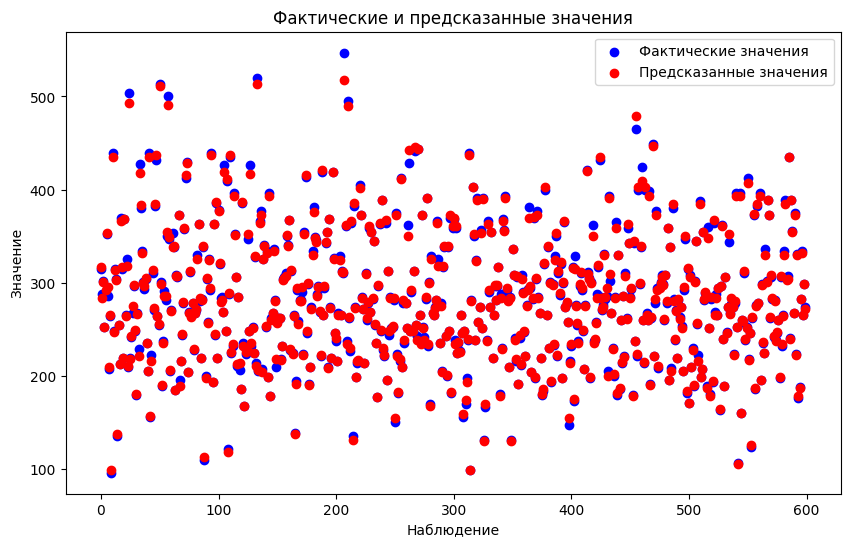

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Gradient Boosting Regressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

gbr_metrics = CommonFunc.getMetrics(y_test, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 5
[LightGBM] [Info] Start training from score 276.239167
*****************
Метрики качества:
*****************
MAE: 2.4310032450
MSE: 44.9843491129
RMSE: 6.7070372828
R²: 0.9912931756


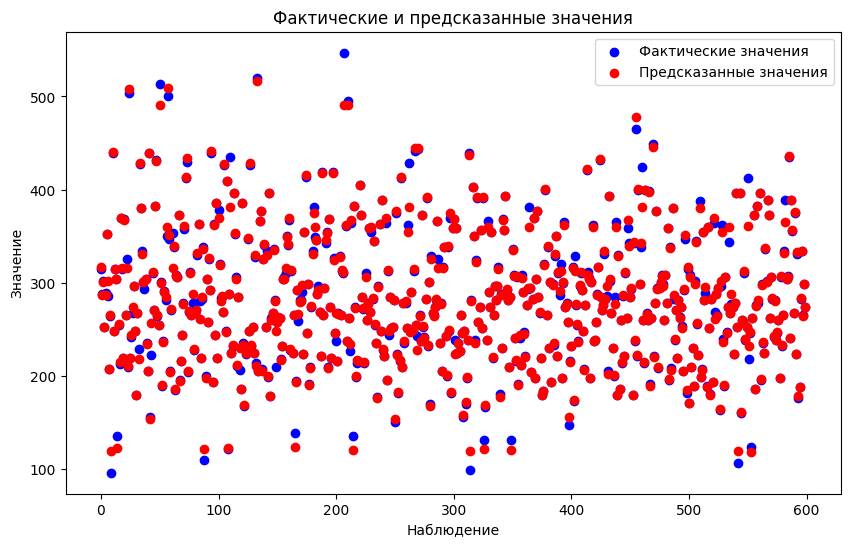

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#LGBMRegressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from lightgbm import LGBMRegressor

lgbm = LGBMRegressor() # параметры
lgbm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lgbm.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 1.5026529312
MSE: 34.8277529753
RMSE: 5.9015042977
R²: 0.9932590082


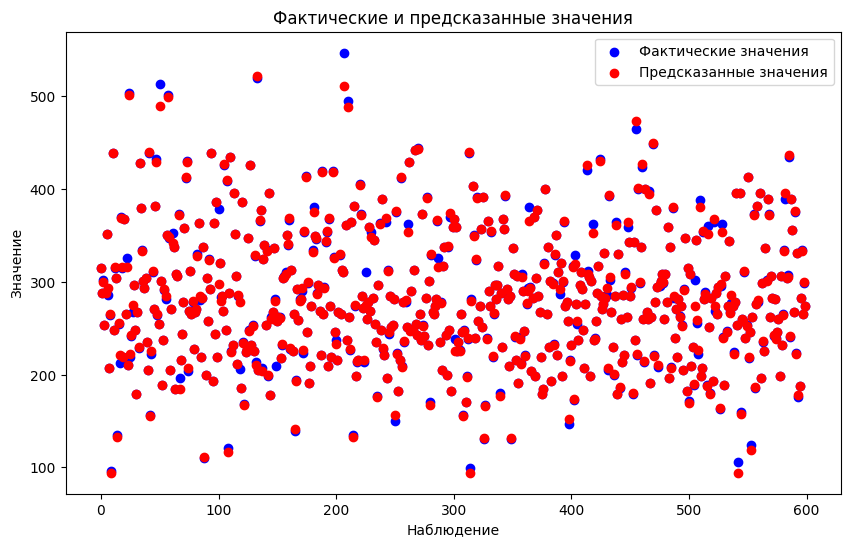

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#XGB Regressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from xgboost import XGBRegressor

xgb = XGBRegressor() # параметры
xgb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
xgb_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 14.5461822546
MSE: 614.6716667438
RMSE: 24.7925728141
R²: 0.8810288830


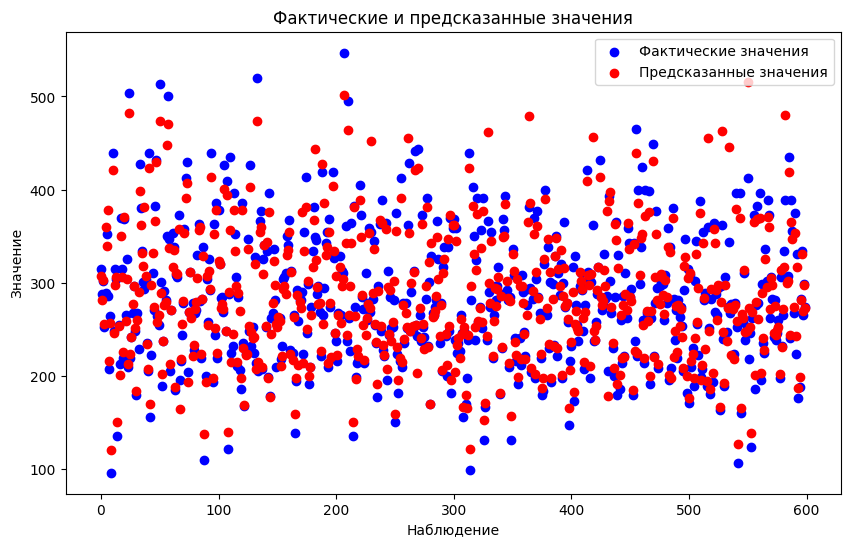

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Elastic net
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from sklearn.linear_model import ElasticNet

par = ElasticNet(alpha=0.2, l1_ratio=0.7, random_state=42) # параметры
par.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = par.predict(X_test)

# Вычисление метрик
par_metrics = CommonFunc.getMetrics(y_test, y_pred)


*****************
Метрики качества:
*****************
MAE: 14.6826058318
MSE: 673.2583881621
RMSE: 25.9472231301
R²: 0.8696892881


C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


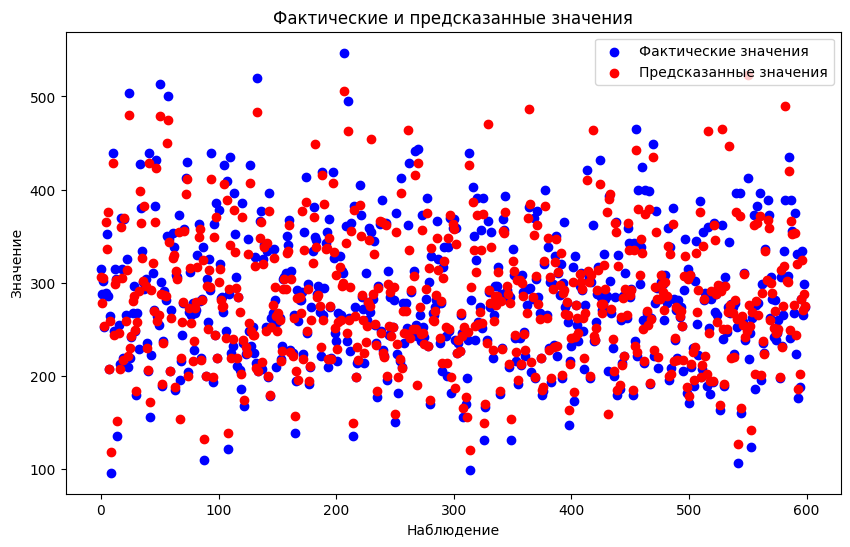

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Huber regressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(epsilon=5) # параметры
huber.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = huber.predict(X_test)

# Вычисление метрик
huber_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 14.2150550752
MSE: 815.7781634303
RMSE: 28.5618305336
R²: 0.8421042573


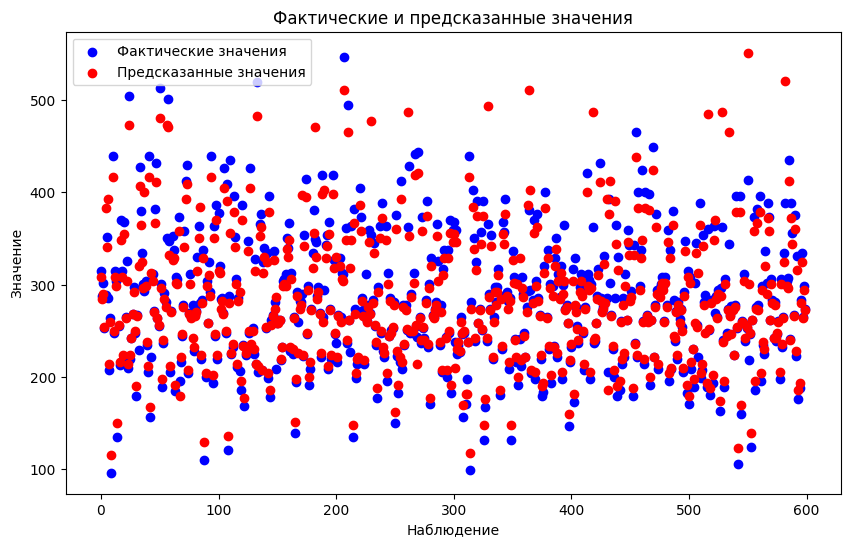

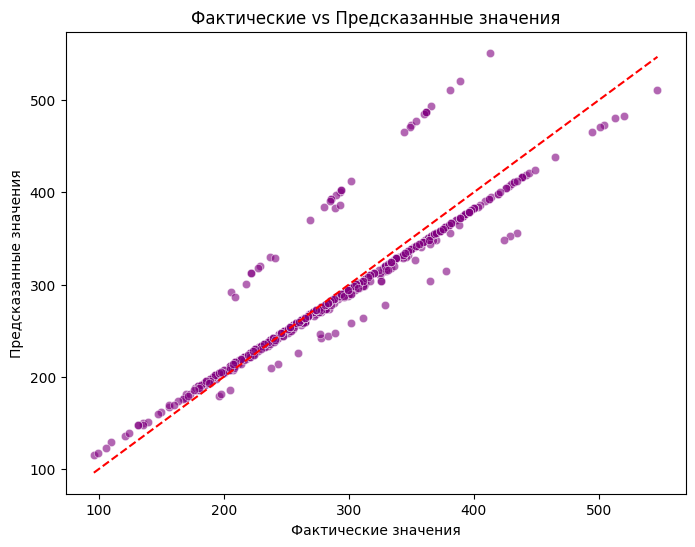

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Линейная регресия для одной колонки
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

X = numdata[['Fuel Consumption Comb (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

lr = LinearRegression() 
lr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lr.predict(X_test)

# Вычисление метрик
lr_metrics = CommonFunc.getMetrics(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения')
plt.show()

*****************
Метрики качества ['Z', 'X']:
*****************
MAE: 1.8349000641
MSE: 5.5867045812
RMSE: 2.3636210739
R²: 0.9987170138

*****************
Метрики качества ['D']:
*****************
MAE: 1.4471447871
MSE: 10.1643655715
RMSE: 3.1881602173
R²: 0.9969117014

*****************
Метрики качества ['E']:
*****************
MAE: 3.1341264020
MSE: 16.2090448052
RMSE: 4.0260458027
R²: 0.9939612588

*****************
Метрики качества:
*****************
MAE: 1.8680638755
MSE: 6.1353817098
RMSE: 2.4769702682
R²: 0.9985815154


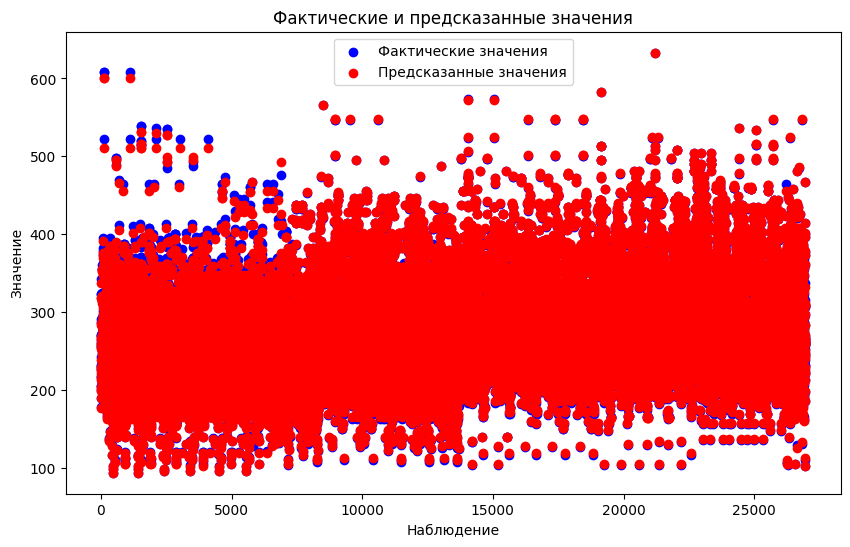

In [13]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Линейная регресия с разделением на типы топлива. Обучаем три разных модели Линейний регресии в зависимости от типа топлива.
#X-Бензин высокого качества
#Z-Бензин низкого качества
#D-дизель
#E-этанол
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def LinearRegressionForVariousFuelType(fuel_types: list):
    new_df = df[df['Fuel Type'].isin(fuel_types)]
    
    X = new_df[['Fuel Consumption Comb (L/100 km)']]
    y = new_df[['CO2 Emissions(g/km)']].values.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    model = RandomForestRegressor() 
    
    lr = LinearRegression() 
    lr.fit(X_train, y_train)
    
    # Предсказание на тестовой выборке
    y_pred = lr.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'*****************')
    print('Метрики качества ' + fuel_types.__str__() + ':')
    print(f'*****************')
    print(f'MAE: {mae:.10f}')
    print(f'MSE: {mse:.10f}')
    print(f'RMSE: {rmse:.10f}')
    print(f'R²: {r2:.10f}')
    print('')
    return lr 

lrXZ = LinearRegressionForVariousFuelType(['Z','X'])
lrD = LinearRegressionForVariousFuelType(['D'])
lrE = LinearRegressionForVariousFuelType(['E'])




def predictionLRDiffFuelType(fuel_type, fuel_consumption):
    if fuel_type == 'Z' or fuel_type == 'X':
       return lrXZ.predict(((fuel_consumption,),))[0]
    if fuel_type == 'D':
       return lrD.predict(((fuel_consumption,),))[0]
    if fuel_type == 'E':
       return lrE.predict(((fuel_consumption,),))[0]




new_df = df[df['Fuel Type'] !='N']
X = new_df[['Fuel Consumption Comb (L/100 km)', 'Fuel Type']]
y = new_df[['CO2 Emissions(g/km)']].values.ravel()
y_pred = []

for x_x in X.values:
    y_pred.append(predictionLRDiffFuelType(x_x[1], x_x[0]))

lr_fueltype_metrics = CommonFunc.getMetrics(y, y_pred)    


Best parameters found: {'bootstrap': True, 'max_depth': 20, 'max_features': 1, 'min_samples_split': 20, 'n_estimators': 100}
*****************
Метрики качества:
*****************
MAE: 11.0370478658
MSE: 644.1163575501
RMSE: 25.3794475423
R²: 0.8753297953


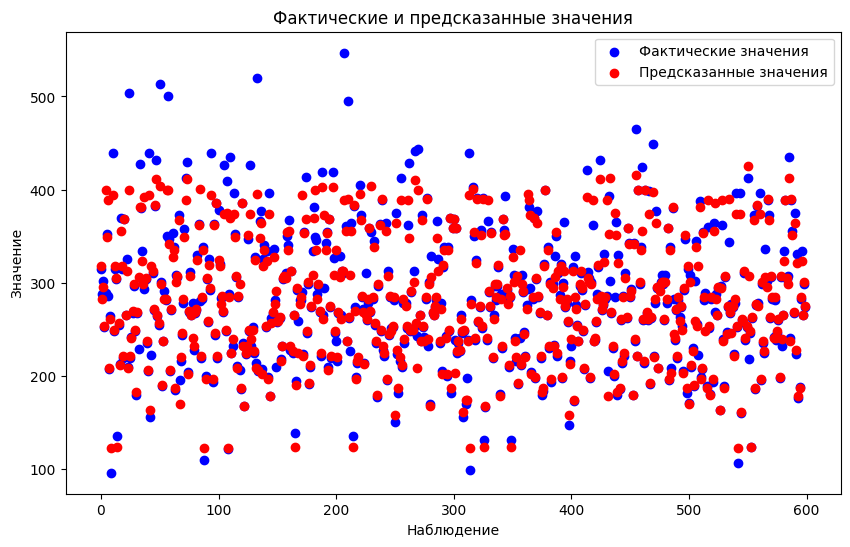

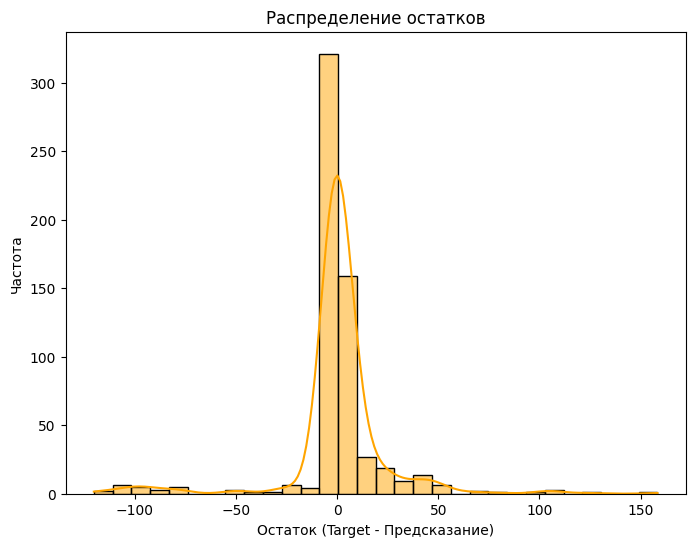

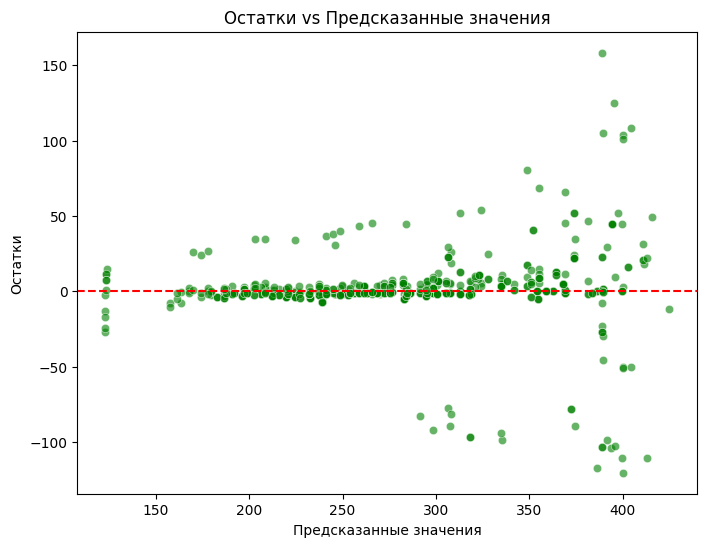

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Рандом форест для одной колонки
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.model_selection import GridSearchCV


X = numdata[['Fuel Consumption Comb (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_fc = RandomForestRegressor(**best_params) 
rfr_fc.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_fc.predict(X_test)

# Вычисление метрик
rfr_fc_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#мой автомобиль (гугл пишет что 149 - 191 г/км)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

my_y = xgb.predict(((6.5,0,7.5,2.0,2004),))
print(my_y[0]) 

my_y_2 = predictionLRDiffFuelType('D', 6.0)
print(my_y_2)

134.39279
161.24564324801335


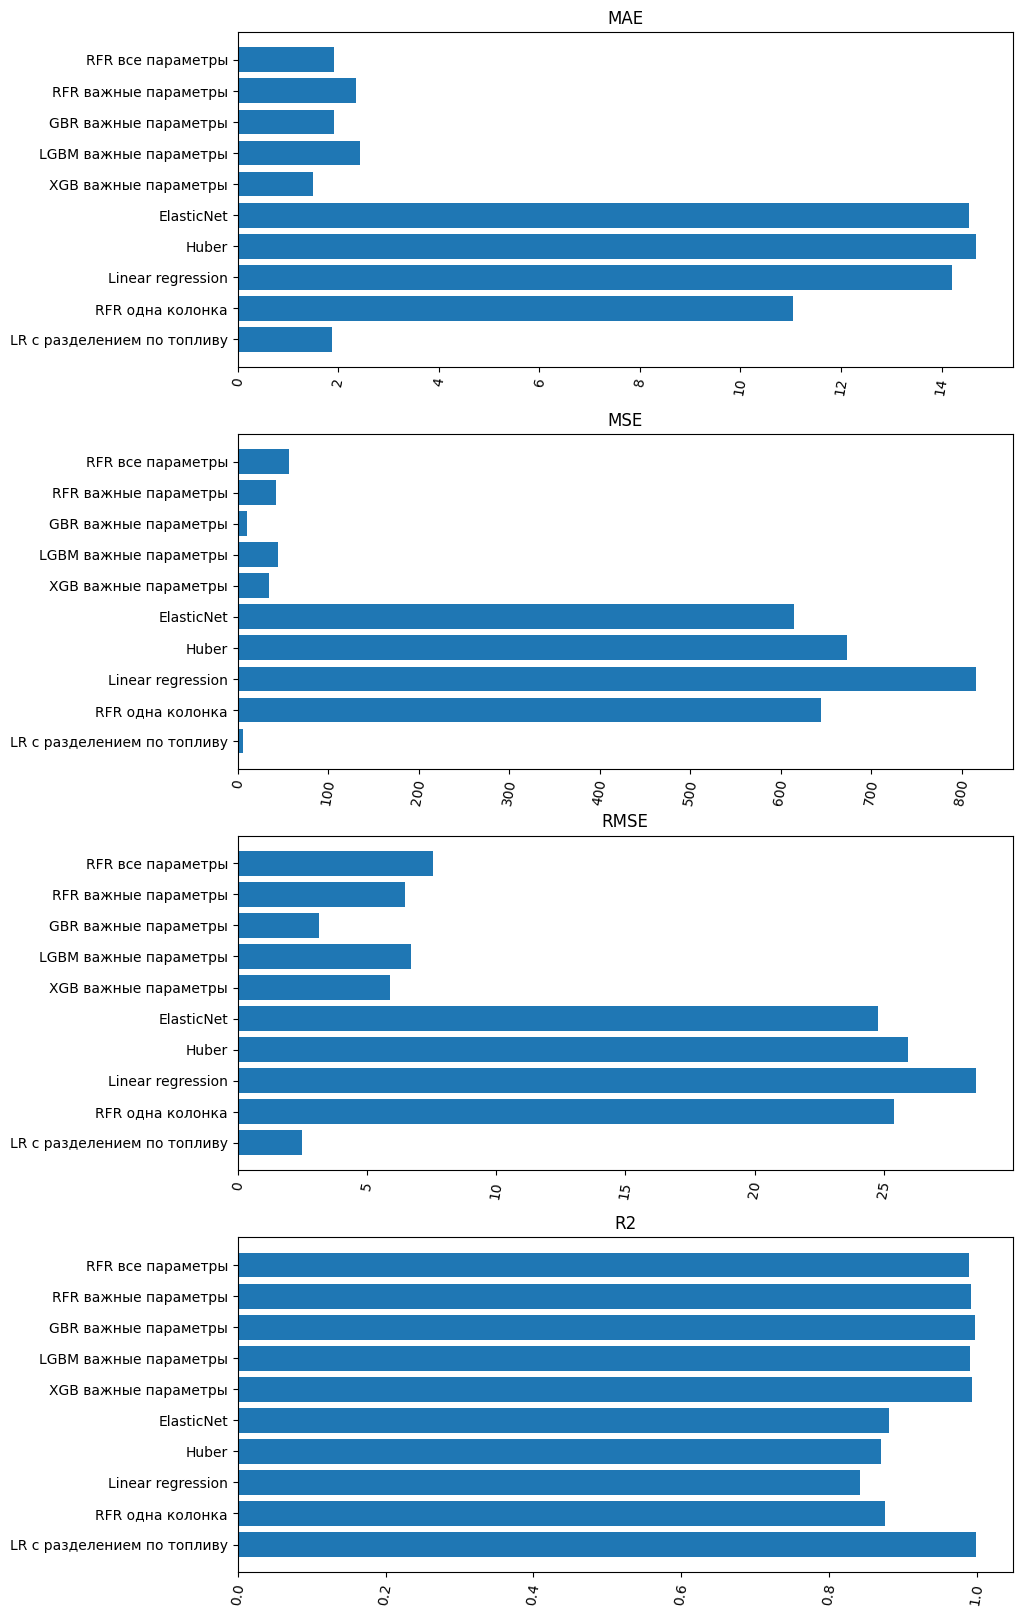

In [16]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Визуализация метрик
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import matplotlib.pyplot as plt

names =('RFR все параметры', 'RFR важные параметры', 'GBR важные параметры', 'LGBM важные параметры', 
        'XGB важные параметры', 'ElasticNet', 'Huber', 'Linear regression','RFR одна колонка', 'LR с разделением по топливу')

mae = (rfr_metrics[0], rfr_data_part_metrics[0], gbr_metrics[0], lgbm_metrics[0], xgb_metrics[0], par_metrics[0], huber_metrics[0], lr_metrics[0], rfr_fc_metrics[0], lr_fueltype_metrics[0])
mse = (rfr_metrics[1], rfr_data_part_metrics[1], gbr_metrics[1], lgbm_metrics[1], xgb_metrics[1], par_metrics[1], huber_metrics[1], lr_metrics[1], rfr_fc_metrics[1], lr_fueltype_metrics[1])
rmse = (rfr_metrics[2], rfr_data_part_metrics[2], gbr_metrics[2], lgbm_metrics[2], xgb_metrics[2], par_metrics[2], huber_metrics[2], lr_metrics[2], rfr_fc_metrics[2], lr_fueltype_metrics[2])
r2 = (rfr_metrics[3], rfr_data_part_metrics[3], gbr_metrics[3], lgbm_metrics[3], xgb_metrics[3], par_metrics[3], huber_metrics[3], lr_metrics[3], rfr_fc_metrics[3], lr_fueltype_metrics[3])

fig, axs = plt.subplots(4, 1)
fig.set_figheight(20)
fig.set_figwidth(10)

axs[0].title.set_text('MAE')
axs[0].tick_params(axis='x', rotation=80)
axs[0].barh(names, mae)
axs[0].invert_yaxis()

axs[1].title.set_text('MSE')
axs[1].tick_params(axis='x', rotation=80)
axs[1].barh(names, mse)
axs[1].invert_yaxis()

axs[2].title.set_text('RMSE')
axs[2].tick_params(axis='x', rotation=80)
axs[2].barh(names, rmse)
axs[2].invert_yaxis()

axs[3].title.set_text('R2')
axs[3].tick_params(axis='x', rotation=80)
axs[3].barh(names, r2)
axs[3].invert_yaxis()


50
*****************
Метрики качества:
*****************
MAE: 18.0510000000
MSE: 1069.0460500000
RMSE: 32.6962696649
R²: 0.8620445116


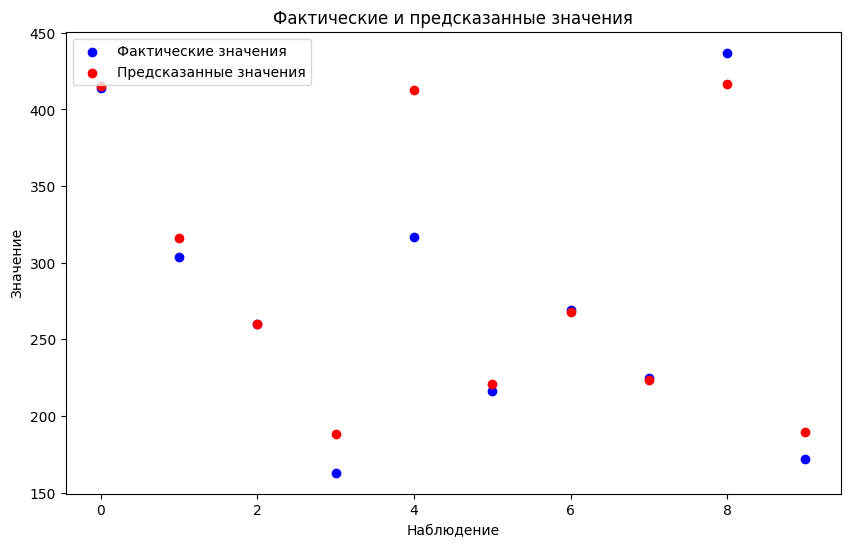

100
*****************
Метрики качества:
*****************
MAE: 17.1341000000
MSE: 1181.7278162000
RMSE: 34.3762682122
R²: 0.6171413060


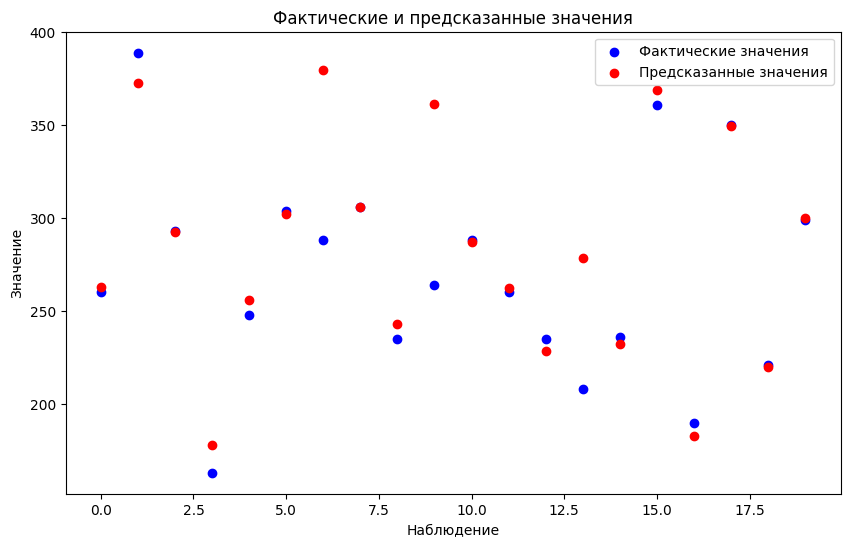

500
*****************
Метрики качества:
*****************
MAE: 3.5882000000
MSE: 80.7155020000
RMSE: 8.9841806527
R²: 0.9804325088


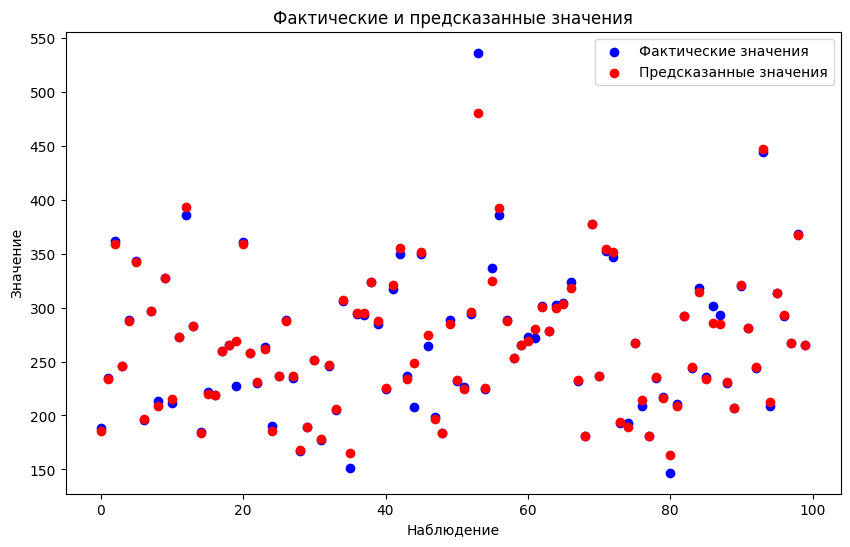

1000
*****************
Метрики качества:
*****************
MAE: 1.6690875000
MSE: 15.5078190313
RMSE: 3.9379968298
R²: 0.9960946214


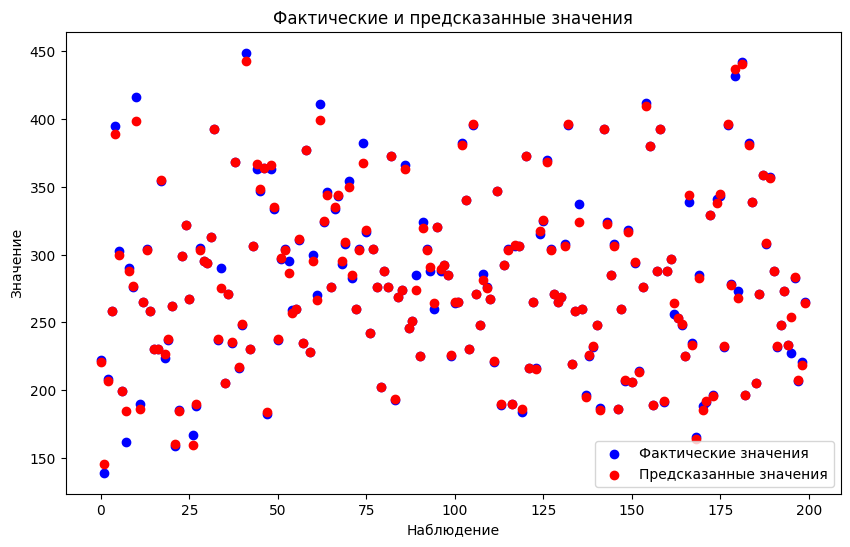

5000
*****************
Метрики качества:
*****************
MAE: 0.8892943571
MSE: 21.1732983406
RMSE: 4.6014452448
R²: 0.9952907465


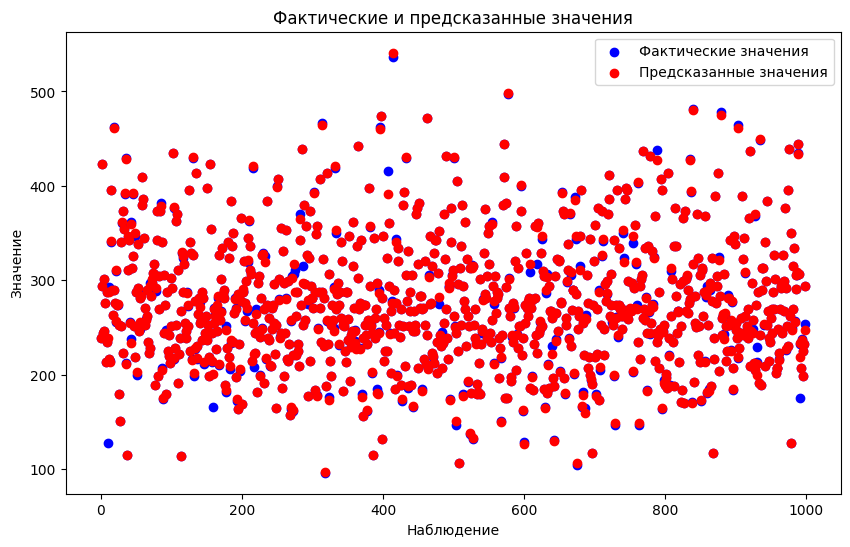

10000
*****************
Метрики качества:
*****************
MAE: 0.5876731091
MSE: 10.6260449994
RMSE: 3.2597614943
R²: 0.9973464689


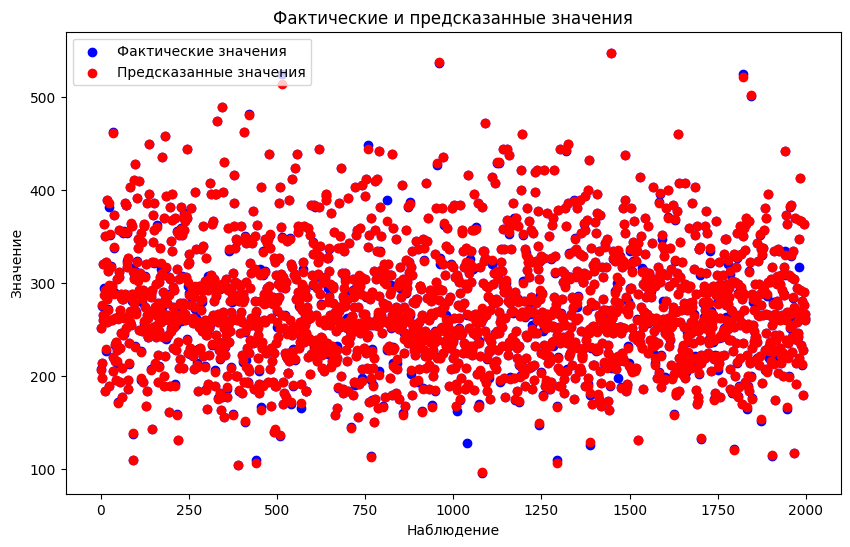

15000
*****************
Метрики качества:
*****************
MAE: 0.4356368016
MSE: 4.0054305111
RMSE: 2.0013571673
R²: 0.9990612495


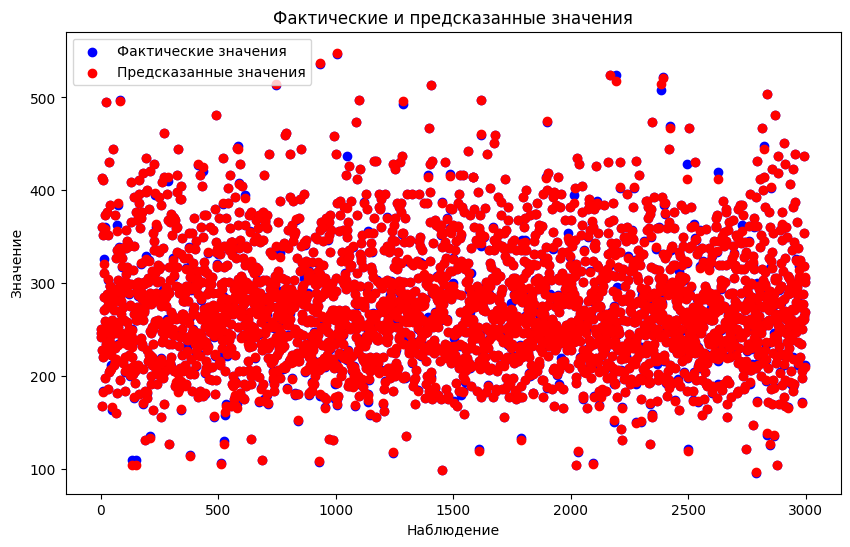

20000
*****************
Метрики качества:
*****************
MAE: 0.3055625420
MSE: 1.1374363562
RMSE: 1.0665066133
R²: 0.9997359469


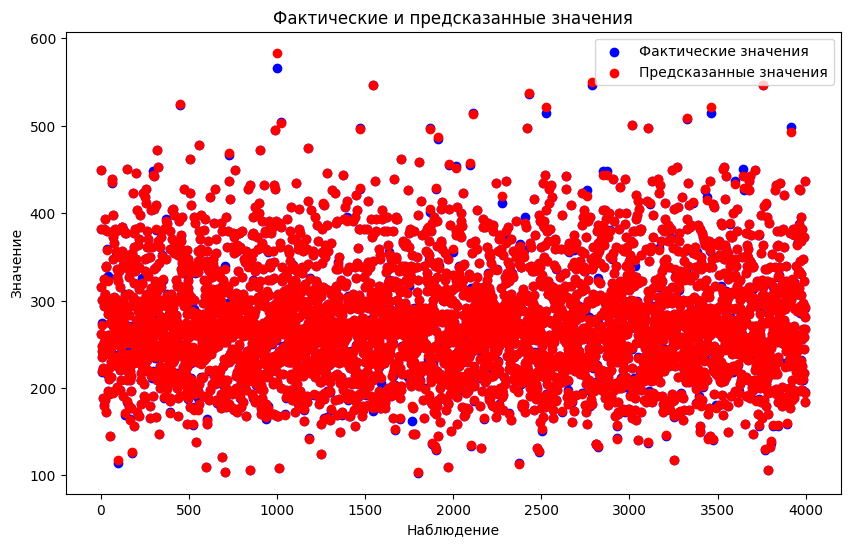

26961
*****************
Метрики качества:
*****************
MAE: 0.3332182789
MSE: 3.5883790238
RMSE: 1.8943017246
R²: 0.9991723311


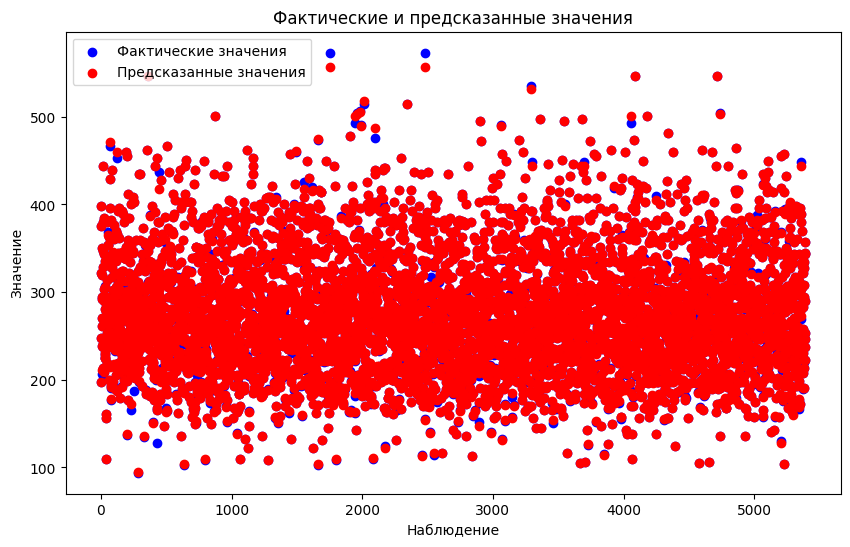

(0.33321827891909495,
 3.588379023829888,
 1.8943017246019411,
 0.9991723310704206)

In [17]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_shafling = df.sample(frac = 1)


def LearnByAmountOfData(n_samples):
    df_part = df_shafling[:n_samples]
    
    #выделяем числовые данные
    numdata = pd.DataFrame(df_part[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                               'Fuel Consumption Comb (L/100 km)', 'Year',
                               'CO2 Emissions(g/km)']])
    
    # Делаем энкодинг для категориальных признаков
    label_encoder_2 = LabelEncoder()
    label_encoder_3 = LabelEncoder()
    
    
    fuel_type = df_part[['Fuel Type']].values.ravel()
    
    encoded_fuel_type = label_encoder_2.fit_transform(fuel_type)
    
    X_ = numdata[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Year']]
    X_['Fuel Type'] = encoded_fuel_type
    feature_names = X_.columns
    X=X_.values
    
    print(len(X))
    #Составляем и упрощаем до одномерного массива набор целевой переменной
    y = numdata[['CO2 Emissions(g/km)']].values.ravel()
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Используем Random Forest чтобы найти наиболее важные признаки
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_test)
    
    rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)
    return rfr_metrics


LearnByAmountOfData(50)
LearnByAmountOfData(100)
LearnByAmountOfData(500)
LearnByAmountOfData(1000)
LearnByAmountOfData(5000)
LearnByAmountOfData(10000)
LearnByAmountOfData(15000)
LearnByAmountOfData(20000)
LearnByAmountOfData(27000)
